In [ ]:
%%capture
# Basics
!pip install emojis
!pip install stargazer
!pip install textstat

import emojis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import seaborn as sns
plt.style.use("seaborn-paper")

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.ticker as ticker

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan


from textstat import flesch_reading_ease, smog_index

from stargazer.stargazer import Stargazer, LineLocation

In [ ]:
# Load colab packages
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data
df = pd.read_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Final/df_final.csv')
df.shape

(2351, 45)

In [ ]:
# df for emoijs
df_emoijs = df[df['Total_emoijs'] > 200].copy()
df_emo = df_emoijs

In [ ]:
Counter(df_emo['emotion_gpt'])

Counter({'pride': 127,
         'determination': 156,
         'gratitude': 199,
         'optimism': 20,
         'outrage': 36,
         'neutral': 23,
         'patriotism': 18,
         'defiance': 36,
         'concern': 17,
         'hope': 10,
         'fear': 6})

## Outliers

I saw some extreme values to which the estimates are likely to be sensitive. This is why I create two dfs.

In [ ]:
# Visualise outliers
def outlier_views(df_v_f, df_emo, out_name):
  fig, axs = plt.subplots(3)

  # Boxplot for 'views'
  sns.boxplot(x=df_v_f['views'], ax=axs[1])
  axs[1].set_title('Views')
  axs[1].set(xlabel=None)  # Remove x label

  # Boxplot for 'forwards'
  sns.boxplot(x=df_v_f['forwards'], ax=axs[0])
  axs[0].set_title('Forwards')
  axs[0].set(xlabel=None)  # Remove x label

  # Boxplot for 'Total_emoijs'
  sns.boxplot(x=df_emo['Total_emoijs'], ax=axs[2])
  axs[2].set_title('Reactions')
  axs[2].set(xlabel=None)  # Remove x label

  # Show the plot
  plt.tight_layout()
  plt.savefig(f'/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Images/{out_name}.png',
              dpi=300)
  plt.show()


In [ ]:
# Vis before outlier removal
outlier_views(df, df_emoijs, 'boxplots_before')

NameError: ignored

In [ ]:
def remove_outliers(outcome, df=df):
  df_in = df.copy()
  Q1 = df_in[outcome].quantile(0.25)
  Q3 = df_in[outcome].quantile(0.75)
  IQR = Q3 - Q1

  df_in = df_in[~((df_in[outcome] < (Q1 - 2 * IQR)) | (df_in[outcome] > (Q3 + 2 * IQR)))]
  print(df_in.shape)
  return df_in

# Two df with outlier removes
#df_out = remove_outliers('views', df=df)
df_emo_out = remove_outliers('Total_emoijs', df=df_emoijs)

(633, 45)


In [ ]:
def remove_outliers_same(df, column_names):
    df_out = df.copy()
    outlier_indices = []

    for col in column_names:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 2 * IQR
        upper_bound = Q3 + 2 * IQR

        outliers = df_out[(df_out[col] < lower_bound) | (df_out[col] > upper_bound)].index
        outlier_indices.extend(outliers)

    # remove duplicates from the list of outlier indices
    outlier_indices = list(set(outlier_indices))

    # drop rows with outlier indices
    df_out = df_out.drop(outlier_indices)
    print(df_out.shape)
    return df_out

df_out = remove_outliers_same(df=df, column_names=['views', 'forwards'])

(2142, 45)


In [ ]:
df.shape[0] - df_out.shape[0]

209

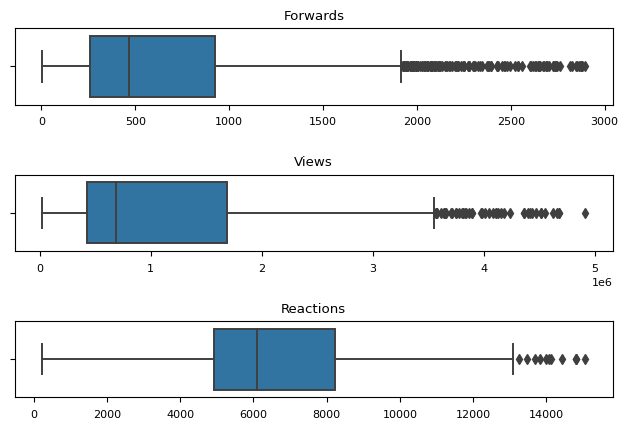

In [ ]:
# Distributions after outlier removal
outlier_views(df_out, df_emo_out, 'boxplots_after')

# Pooled OLS Analysis

Possible regression equation

$$
Y_i = \beta_0 + \sum_{j} \beta_{1j} \cdot \text{Emotion}_{ij} + \beta_2 \cdot \text{Week}_i + \beta_3 \cdot \text{Hour}_i +  \beta_4 \cdot X + \epsilon_i
$$


where $i$ indexes all messages, $i={1,...,N}$; $emotion_{i}$ is the emotion of message $i$; $X_{i}$ is a matrix text controls (e.g. topic, text length, containing URL, etc.); and $T_{i}$ is a matrix of time controls (weekly and hourly).

In [ ]:
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

In [ ]:
df.index

Index(['2022-02-24 04:42:52+00:00', '2022-02-24 06:48:58+00:00',
       '2022-02-24 15:35:31+00:00', '2022-02-24 21:26:30+00:00',
       '2022-02-24 22:35:02+00:00', '2022-02-25 05:10:20+00:00',
       '2022-02-25 08:06:50+00:00', '2022-02-25 11:17:19+00:00',
       '2022-02-25 16:55:42+00:00', '2022-02-25 21:59:12+00:00',
       ...
       '2023-06-09 09:31:44+00:00', '2023-06-09 14:30:41+00:00',
       '2023-06-09 16:58:22+00:00', '2023-06-10 12:34:45+00:00',
       '2023-06-10 14:50:11+00:00', '2023-06-10 15:47:03+00:00',
       '2023-06-11 06:41:42+00:00', '2023-06-11 08:41:55+00:00',
       '2023-06-11 18:23:18+00:00', '2023-06-11 20:07:05+00:00'],
      dtype='object', name='date', length=2141)

## GPT regressions

In [ ]:
# maxlags for NW SE
int(4*(df.shape[0]/100)**(2/9))

7

In [ ]:
df.columns

Index(['date', 'Unnamed: 0.1', 'Unnamed: 0', 'id', 'message', 'views',
       'forwards', 'reactions', 'mime_type', '😢', '🙏', '❤', '👍',
       'Total_emoijs', 'message_both', 'message_split_en', 'message_split_uk',
       'message_lan', 'message_score', 'en_original', 'uk_trans',
       'message_final', 'topic', 'topic_no_outliers', 'emotion_gpt',
       'sentiment', 'x_nchars', 'x_contains_emoij', 'x_year', 'x_month',
       'x_weekofyear', 'x_monthofyear', 'x_day', 'x_weekday', 'x_hour',
       'x_weekofyear_cat', 'x_monthofyear_cat', 'russia', 'x_periodofday',
       'flesch_reading_ease', 'smog_index', 'log_views', 'log_forwards',
       'log_Total_emoijs'],
      dtype='object')

### Final reg function


In [ ]:
# Functions with paramters
def final_regs(df, df_emoijs, time_dummies='x_monthofyear_cat', topic='topic', cov_type='HC3', cov_kwds={}):
  # Controls
  controls = f'C({topic}) + C(mime_type) + C(x_periodofday) + C({time_dummies}) + x_nchars + C(x_contains_emoij) + flesch_reading_ease + smog_index'

  # VIEWS

  # Emotions
  ba_gpt_views = f'log_views ~ C(emotion_gpt, Treatment(reference="neutral"))'
  co_gpt_views = f'log_views ~ C(emotion_gpt, Treatment(reference="neutral")) + {controls}'

  ols_ba_gpt_views = smf.ols(formula = ba_gpt_views, data=df).fit()
  ols_ba_gpt_views_rob = smf.ols(formula = ba_gpt_views, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_ba_gpt_views_clus = smf.ols(formula = ba_gpt_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

  ols_co_gpt_views = smf.ols(formula = co_gpt_views, data=df).fit()
  ols_co_gpt_views_rob = smf.ols(formula = co_gpt_views, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_co_gpt_views_clus = smf.ols(formula = co_gpt_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

  # Sentiment
  ba_sent_views = f'log_views ~ C(sentiment, Treatment(reference="neutral"))'
  co_sent_views = f'log_views ~ C(sentiment, Treatment(reference="neutral")) + {controls}'

  ols_ba_sent_views = smf.ols(formula = ba_sent_views, data=df).fit()
  ols_ba_sent_views_rob = smf.ols(formula = ba_sent_views, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_ba_sent_views_clus = smf.ols(formula = ba_sent_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

  ols_co_sent_views = smf.ols(formula = co_sent_views, data=df).fit()
  ols_co_sent_views_rob = smf.ols(formula = co_sent_views, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_co_sent_views_clus = smf.ols(formula = co_sent_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

  # FORWARDS
  # Emotions
  ba_gpt_forwards = f'log_forwards ~ C(emotion_gpt, Treatment(reference="neutral"))'
  co_gpt_forwards = f'log_forwards ~ C(emotion_gpt, Treatment(reference="neutral")) + {controls}'

  ols_ba_gpt_forwards = smf.ols(formula = ba_gpt_forwards, data=df).fit()
  ols_ba_gpt_forwards_rob = smf.ols(formula = ba_gpt_forwards, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds) # HC3
  ols_ba_gpt_forwards_clus = smf.ols(formula = ba_gpt_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})


  ols_co_gpt_forwards = smf.ols(formula = co_gpt_forwards, data=df).fit()
  ols_co_gpt_forwards_rob = smf.ols(formula = co_gpt_forwards, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_co_gpt_forwards_clus = smf.ols(formula = co_gpt_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

  # Sentiment
  ba_sent_forwards = f'log_forwards ~ C(sentiment, Treatment(reference="neutral"))'
  co_sent_forwards = f'log_forwards ~ C(sentiment, Treatment(reference="neutral")) + {controls}'

  ols_ba_sent_forwards = smf.ols(formula = ba_sent_forwards, data=df).fit()
  ols_ba_sent_forwards_rob = smf.ols(formula = ba_sent_forwards, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_ba_sent_forwards_clus = smf.ols(formula = ba_sent_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

  ols_co_sent_forwards = smf.ols(formula = co_sent_forwards, data=df).fit()
  ols_co_sent_forwards_rob = smf.ols(formula = co_sent_forwards, data=df).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_co_sent_forwards_clus = smf.ols(formula = co_sent_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

  # TOTE
  # Emotions
  ba_gpt_tote = f'log_Total_emoijs ~ C(emotion_gpt, Treatment(reference="neutral"))'
  co_gpt_tote = f'log_Total_emoijs ~ C(emotion_gpt, Treatment(reference="neutral")) + {controls}'

  ols_ba_gpt_tote = smf.ols(formula = ba_gpt_tote, data=df_emoijs).fit()
  ols_ba_gpt_tote_rob = smf.ols(formula = ba_gpt_tote, data=df_emoijs).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_ba_gpt_tote_clus = smf.ols(formula = ba_gpt_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

  ols_co_gpt_tote = smf.ols(formula = co_gpt_tote, data=df_emoijs).fit()
  ols_co_gpt_tote_rob = smf.ols(formula = co_gpt_tote, data=df_emoijs).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_co_gpt_tote_clus = smf.ols(formula = co_gpt_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

  # Sentiment
  ba_sent_tote = f'log_Total_emoijs ~ C(sentiment, Treatment(reference="neutral"))'
  co_sent_tote = f'log_Total_emoijs ~ C(sentiment, Treatment(reference="neutral")) + {controls}'

  ols_ba_sent_tote = smf.ols(formula = ba_sent_tote, data=df_emoijs).fit()
  ols_ba_sent_tote_rob = smf.ols(formula = ba_sent_tote, data=df_emoijs).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_ba_sent_tote_clus = smf.ols(formula = ba_sent_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

  ols_co_sent_tote = smf.ols(formula = co_sent_tote, data=df_emoijs).fit()
  ols_co_sent_tote_rob = smf.ols(formula = co_sent_tote, data=df_emoijs).fit(cov_type=cov_type, cov_kwds=cov_kwds)
  ols_co_sent_tote_clus = smf.ols(formula = co_sent_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

  return [ols_ba_sent_views_rob,
               ols_co_sent_views_rob,
               ols_ba_gpt_views_rob,
               ols_co_gpt_views_rob,
               ols_ba_sent_forwards_rob,
               ols_co_sent_forwards_rob,
               ols_ba_gpt_forwards_rob,
               ols_co_gpt_forwards_rob,
               ols_ba_sent_tote_rob,
               ols_co_sent_tote_rob,
               ols_ba_gpt_tote_rob,
               ols_co_gpt_tote_rob]

In [ ]:
# Emotions
controls = 'C(topic) + C(mime_type) + C(x_hour) + C(x_weekofyear_cat) + x_nchars + C(x_contains_emoij) + flesch_reading_ease + smog_index'

# Log outcomes
# Cluster-robust: cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]}
# Robust SE: cov_type = "HC0"

# VIEWS

# Emotions
ba_gpt_views = f'log_views ~ C(emotion_gpt, Treatment(reference="neutral"))'
co_gpt_views = f'log_views ~ C(emotion_gpt, Treatment(reference="neutral")) + {controls}'

ols_ba_gpt_views = smf.ols(formula = ba_gpt_views, data=df).fit()
ols_ba_gpt_views_rob = smf.ols(formula = ba_gpt_views, data=df).fit(cov_type = "HC3")
ols_ba_gpt_views_clus = smf.ols(formula = ba_gpt_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

ols_co_gpt_views = smf.ols(formula = co_gpt_views, data=df).fit()
ols_co_gpt_views_rob = smf.ols(formula = co_gpt_views, data=df).fit(cov_type = "HC3")
ols_co_gpt_views_clus = smf.ols(formula = co_gpt_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

# Sentiment
ba_sent_views = f'log_views ~ C(sentiment, Treatment(reference="neutral"))'
co_sent_views = f'log_views ~ C(sentiment, Treatment(reference="neutral")) + {controls}'

ols_ba_sent_views = smf.ols(formula = ba_sent_views, data=df).fit()
ols_ba_sent_views_rob = smf.ols(formula = ba_sent_views, data=df).fit(cov_type = "HC3")
ols_ba_sent_views_clus = smf.ols(formula = ba_sent_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

ols_co_sent_views = smf.ols(formula = co_sent_views, data=df).fit()
ols_co_sent_views_rob = smf.ols(formula = co_sent_views, data=df).fit(cov_type = "HC3")
ols_co_sent_views_clus = smf.ols(formula = co_sent_views, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

# FORWARDS
# Emotions
ba_gpt_forwards = f'log_forwards ~ C(emotion_gpt, Treatment(reference="neutral"))'
co_gpt_forwards = f'log_forwards ~ C(emotion_gpt, Treatment(reference="neutral")) + {controls}'

ols_ba_gpt_forwards = smf.ols(formula = ba_gpt_forwards, data=df).fit()
ols_ba_gpt_forwards_rob = smf.ols(formula = ba_gpt_forwards, data=df).fit(cov_type = "HC3")
ols_ba_gpt_forwards_clus = smf.ols(formula = ba_gpt_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})


ols_co_gpt_forwards = smf.ols(formula = co_gpt_forwards, data=df).fit()
ols_co_gpt_forwards_rob = smf.ols(formula = co_gpt_forwards, data=df).fit(cov_type = "HC3")
ols_co_gpt_forwards_clus = smf.ols(formula = co_gpt_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

# Sentiment
ba_sent_forwards = f'log_forwards ~ C(sentiment, Treatment(reference="neutral"))'
co_sent_forwards = f'log_forwards ~ C(sentiment, Treatment(reference="neutral")) + {controls}'

ols_ba_sent_forwards = smf.ols(formula = ba_sent_forwards, data=df).fit()
ols_ba_sent_forwards_rob = smf.ols(formula = ba_sent_forwards, data=df).fit(cov_type = "HC3")
ols_ba_sent_forwards_clus = smf.ols(formula = ba_sent_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

ols_co_sent_forwards = smf.ols(formula = co_sent_forwards, data=df).fit()
ols_co_sent_forwards_rob = smf.ols(formula = co_sent_forwards, data=df).fit(cov_type = "HC3")
ols_co_sent_forwards_clus = smf.ols(formula = co_sent_forwards, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["x_weekofyear_cat"]})

# TOTE
# Emotions
ba_gpt_tote = f'log_Total_emoijs ~ C(emotion_gpt, Treatment(reference="neutral"))'
co_gpt_tote = f'log_Total_emoijs ~ C(emotion_gpt, Treatment(reference="neutral")) + {controls}'

ols_ba_gpt_tote = smf.ols(formula = ba_gpt_tote, data=df_emoijs).fit()
ols_ba_gpt_tote_rob = smf.ols(formula = ba_gpt_tote, data=df_emoijs).fit(cov_type = "HC3")
ols_ba_gpt_tote_clus = smf.ols(formula = ba_gpt_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

ols_co_gpt_tote = smf.ols(formula = co_gpt_tote, data=df_emoijs).fit()
ols_co_gpt_tote_rob = smf.ols(formula = co_gpt_tote, data=df_emoijs).fit(cov_type = "HC3")
ols_co_gpt_tote_clus = smf.ols(formula = co_gpt_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

# Sentiment
ba_sent_tote = f'log_Total_emoijs ~ C(sentiment, Treatment(reference="neutral"))'
co_sent_tote = f'log_Total_emoijs ~ C(sentiment, Treatment(reference="neutral")) + {controls}'

ols_ba_sent_tote = smf.ols(formula = ba_sent_tote, data=df_emoijs).fit()
ols_ba_sent_tote_rob = smf.ols(formula = ba_sent_tote, data=df_emoijs).fit(cov_type = "HC3")
ols_ba_sent_tote_clus = smf.ols(formula = ba_sent_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

ols_co_sent_tote = smf.ols(formula = co_sent_tote, data=df_emoijs).fit()
ols_co_sent_tote_rob = smf.ols(formula = co_sent_tote, data=df_emoijs).fit(cov_type = "HC3")
ols_co_sent_tote_clus = smf.ols(formula = co_sent_tote, data=df_emoijs).fit(cov_type="cluster", cov_kwds={"groups": df_emoijs["x_weekofyear_cat"]})

In [ ]:
# Perform the Breusch-Pagan test
import statsmodels.stats.api as sms
bp_test = sms.het_breuschpagan(ols_co_gpt_forwards.resid, ols_co_gpt_forwards.model.exog)

print(f'BP test statistic: {bp_test[0]}')
print(f'BP test p-value: {bp_test[1]}')
round(bp_test[1], 2)

BP test statistic: 276.57451591149214
BP test p-value: 2.8874746948843114e-10


0.0

__Signs__ of heteroscedasticity => justify robust SE

In [ ]:
# def correct_labels(model):
#   # new index correct emotions only
#   return  [re.search(r'\.(\w+)\]', string).group(1) if 'emotion' in string else string \
#                 for string in model.params.index]

In [ ]:
# Get dict of name corrections and selections of variables
def rename_covariates(model):
  '''Takes a model, returns a dict of emotion names'''
  return {em: re.search(r'T\.(\w+)\]', em).group(1) for em in model.params.index if 'neutral' in em}

# Emotions
renamed_emotions_dic = rename_covariates(ols_ba_gpt_forwards)
emotions_name_list = renamed_emotions_dic.keys()

# Sentiment
renamed_sentiments_dic = rename_covariates(ols_ba_sent_views)
sentiments_name_list = renamed_sentiments_dic.keys()

### Emotions

In [ ]:
models_emo_views = [ols_ba_gpt_views, ols_ba_gpt_views_rob, ols_ba_gpt_views_clus, ols_co_gpt_views, ols_co_gpt_views_rob, ols_co_gpt_views_clus]

# Build stargazer table
stargazer_views = Stargazer(models_emo_views)

stargazer_views.covariate_order(emotions_name_list)
stargazer_views.rename_covariates(renamed_emotions_dic)
stargazer_views.add_line('Durbin-Watson', [round(durbin_watson(model.resid), 2) for model in models_emo_views], LineLocation.FOOTER_BOTTOM)
stargazer_views.add_line('Breusch-Pagan (p-value)', [round(het_breuschpagan(model.resid, model.model.exog)[3], 2) for model in models_emo_views], LineLocation.FOOTER_BOTTOM)
stargazer_views.add_line('Time FE', ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOTTOM)
stargazer_views.add_line('Text controls',  ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOTTOM)
stargazer_views.add_line('SE',  ['default', 'robust', 'cluster week', 'default', 'robust', 'cluster week'], LineLocation.FOOTER_BOTTOM)
stargazer_views.title('OLS regression: Views')
stargazer_views.show_f_statistic = False
stargazer_views.show_dof = False
stargazer_views.show_r2 = False
stargazer_views.show_residual_std_err = False
stargazer_views.dep_var_name = 'Dependent variable: views'

stargazer_views

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 145, but rank is 71
  warnings.warn('covariance of constraints does not have full '


In [ ]:
np.mean(df['views'])

1329798.315965583

In [ ]:
models_emo_forwards = [ols_ba_gpt_forwards, ols_ba_gpt_forwards_rob, ols_ba_gpt_forwards_clus, ols_co_gpt_forwards, ols_co_gpt_forwards_rob, ols_co_gpt_forwards_clus]

# Build stargazer table
stargazer_forwards = Stargazer(models_emo_forwards)

stargazer_forwards.covariate_order(emotions_name_list)
stargazer_forwards.rename_covariates(renamed_emotions_dic)
stargazer_forwards.add_line('Durbin-Watson', [round(durbin_watson(model.resid), 2) for model in models_emo_forwards], LineLocation.FOOTER_BOOTM)
stargazer_forwards.add_line('Breusch-Pagan (p-value)', [round(het_breuschpagan(model.resid, model.model.exog)[3], 2) for model in models_emo_forwards], LineLocation.FOOTER_BOOTM)
stargazer_forwards.add_line('Time FE', ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_forwards.add_line('Text controls',  ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_forwards.add_line('SE',  ['default', 'robust', 'cluster week', 'default', 'robust', 'cluster week'], LineLocation.FOOTER_BOOTM)
stargazer_forwards.title('OLS regression: Forwards')
stargazer_forwards.show_f_statistic = False
stargazer_forwards.show_dof = False
stargazer_forwards.show_r2 = False
stargazer_forwards.show_residual_std_err = False
stargazer_forwards.dep_var_name = 'Dependent variable: forwards'

stargazer_forwards

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 141, but rank is 69
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# Build stargazer table
models_emo_tote = [ols_ba_gpt_tote, ols_ba_gpt_tote_rob, ols_ba_gpt_tote_clus, ols_co_gpt_tote, ols_co_gpt_tote_rob, ols_co_gpt_tote_clus]

stargazer_tote = Stargazer([ols_ba_gpt_tote,
                            ols_ba_gpt_tote_rob,
                            ols_ba_gpt_tote_clus,
                            ols_co_gpt_tote,
                            ols_co_gpt_tote_rob,
                            ols_co_gpt_tote_clus])

stargazer_tote.covariate_order(emotions_name_list)
stargazer_tote.rename_covariates(renamed_emotions_dic)
stargazer_tote.add_line('Durbin-Watson', [round(durbin_watson(model.resid), 2) for model in models_emo_tote], LineLocation.FOOTER_BOOTM)
stargazer_tote.add_line('Breusch-Pagan (p-value)', [round(het_breuschpagan(model.resid, model.model.exog)[3], 3
                                                          ) for model in models_emo_tote], LineLocation.FOOTER_BOOTM)
stargazer_tote.add_line('Time FE', ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_tote.add_line('Text controls',  ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_tote.add_line('SE',  ['default', 'robust', 'cluster week', 'default', 'robust', 'cluster week'], LineLocation.FOOTER_BOOTM)
stargazer_tote.title('OLS reegression: Total emoijs')
stargazer_tote.show_f_statistic = False
stargazer_tote.show_dof = False
stargazer_tote.show_r2 = False
stargazer_tote.show_residual_std_err = False
stargazer_tote.dep_var_name = 'Dependent variable: total emoijs'

stargazer_tote

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 84, but rank is 16
  warnings.warn('covariance of constraints does not have full '


### Sentiments

In [ ]:
# Build stargazer table
stargazer_sent_views = Stargazer([ols_ba_sent_views,
                                  ols_ba_sent_views_rob,
                                  ols_ba_sent_views_clus,
                                  ols_co_sent_views,
                                  ols_co_sent_views_rob,
                                  ols_co_sent_views_clus])

stargazer_sent_views.covariate_order(sentiments_name_list)
stargazer_sent_views.rename_covariates(renamed_sentiments_dic)
stargazer_sent_views.add_line('Time FE', ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_sent_views.add_line('Text controls',  ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_sent_views.add_line('SE',  ['default', 'robust', 'cluster week', 'default', 'robust', 'cluster week'], LineLocation.FOOTER_BOOTM)
stargazer_sent_views.title('OLS reegression: Views')
stargazer_sent_views.show_f_statistic = False
stargazer_sent_views.show_dof = False
stargazer_sent_views.show_r2 = False
stargazer_sent_views.show_residual_std_err = False
stargazer_sent_views.dep_var_name = 'Dependent variable: views'

stargazer_sent_views

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 133, but rank is 61
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# Build stargazer table
stargazer_sent_forwards = Stargazer([ols_ba_sent_forwards,
                                  ols_ba_sent_forwards_rob,
                                  ols_ba_sent_forwards_clus,
                                  ols_co_sent_forwards,
                                  ols_co_sent_forwards_rob,
                                  ols_co_sent_forwards_clus])

stargazer_sent_forwards.covariate_order(sentiments_name_list)
stargazer_sent_forwards.rename_covariates(renamed_sentiments_dic)
stargazer_sent_forwards.add_line('Time FE', ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_sent_forwards.add_line('Text controls',  ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_sent_forwards.add_line('SE',  ['default', 'robust', 'cluster week', 'default', 'robust', 'cluster week'], LineLocation.FOOTER_BOOTM)
stargazer_sent_forwards.title('OLS reegression: Forwards')
stargazer_sent_forwards.show_f_statistic = False
stargazer_sent_forwards.show_dof = False
stargazer_sent_forwards.show_r2 = False
stargazer_sent_forwards.show_residual_std_err = False
stargazer_sent_forwards.dep_var_name = 'Dependent variable: Forwards'

stargazer_sent_forwards

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 133, but rank is 61
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# Build stargazer table
stargazer_sent_tote = Stargazer([ols_ba_sent_tote,
                                  ols_ba_sent_tote_rob,
                                  ols_ba_sent_tote_clus,
                                  ols_co_sent_tote,
                                  ols_co_sent_tote_rob,
                                  ols_co_sent_tote_clus])

stargazer_sent_tote.covariate_order(sentiments_name_list)
stargazer_sent_tote.rename_covariates(renamed_sentiments_dic)
stargazer_sent_tote.add_line('Time FE', ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_sent_tote.add_line('Text controls',  ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_sent_tote.add_line('SE',  ['default', 'robust', 'cluster week', 'default', 'robust', 'cluster week'], LineLocation.FOOTER_BOOTM)
stargazer_sent_tote.title('OLS reegression: total emoijs')
stargazer_sent_tote.show_f_statistic = False
stargazer_sent_tote.show_dof = False
stargazer_sent_tote.show_r2 = False
stargazer_sent_tote.show_residual_std_err = False
stargazer_sent_tote.dep_var_name = 'Dependent variable: total emoijs'

stargazer_sent_tote

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 76, but rank is 16
  warnings.warn('covariance of constraints does not have full '


### All regs and out

In [ ]:
# From manual regs
models_forwards_final = [ols_ba_sent_forwards_rob, ols_co_sent_forwards_rob, ols_ba_gpt_forwards_rob, ols_co_gpt_forwards_rob]

# Build stargazer table
stargazer_final_forwards = Stargazer(models_forwards_final)

stargazer_final_forwards.covariate_order(list(sentiments_name_list) + list(emotions_name_list))
stargazer_final_forwards.rename_covariates({**renamed_sentiments_dic, **renamed_emotions_dic})
stargazer_final_forwards.add_line('Durbin-Watson', [round(durbin_watson(model.resid), 2) for model in models_forwards_final], LineLocation.FOOTER_BOOTM)
stargazer_final_forwards.add_line('Breusch-Pagan (p-value)', [round(het_breuschpagan(model.resid, model.model.exog)[3], 2) for model in models_forwards_final], LineLocation.FOOTER_BOOTM)
stargazer_final_forwards.add_line('Time FE', ['No', 'Yes', 'No', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_final_forwards.add_line('Text controls',  ['No', 'Yes', 'No', 'Yes'], LineLocation.FOOTER_BOOTM)
stargazer_final_forwards.add_line('SE',  ['robust', 'robust', 'robust', 'robust'], LineLocation.FOOTER_BOOTM)
stargazer_final_forwards.title('OLS regression: Forwards')
stargazer_final_forwards.show_f_statistic = False
stargazer_final_forwards.show_dof = False
stargazer_final_forwards.show_r2 = False
stargazer_final_forwards.show_residual_std_err = False
stargazer_final_forwards.dep_var_name = 'Dependent variable: Forwards'
stargazer_final_forwards.add_custom_notes(['Parentheses report robust standard errors.'])

stargazer_final_forwards

In [ ]:
# From manual regs
model_final = [ols_ba_sent_views_rob,
               ols_co_sent_views_rob,
               ols_ba_gpt_views_rob,
               ols_co_gpt_views_rob,
               ols_ba_sent_forwards_rob,
               ols_co_sent_forwards_rob,
               ols_ba_gpt_forwards_rob,
               ols_co_gpt_forwards_rob,
               ols_ba_sent_tote_rob,
               ols_co_sent_tote_rob,
               ols_ba_gpt_tote_rob,
               ols_co_gpt_tote_rob]

stargazer_final_all = Stargazer(model_final)

stargazer_final_all.covariate_order(list(sentiments_name_list) + list(emotions_name_list))
stargazer_final_all.rename_covariates({**renamed_sentiments_dic, **renamed_emotions_dic})
stargazer_final_all.add_line('Durbin-Watson', [round(durbin_watson(model.resid), 2) for model in model_final], LineLocation.BODY_BOTTOM)
stargazer_final_all.add_line('Breusch-Pagan', [round(het_breuschpagan(model.resid, model.model.exog)[3], 2) for model in model_final], LineLocation.BODY_BOTTOM)
stargazer_final_all.add_line('Time FE', ['No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes'], LineLocation.BODY_BOTTOM)
stargazer_final_all.add_line('Text controls',  ['No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes'], LineLocation.BODY_BOTTOM)
#stargazer_final_all.add_line('SE',  ['robust', 'robust', 'robust', 'robust'], LineLocation.FOOTER_BOOTM)
stargazer_final_all.show_f_statistic = False
stargazer_final_all.show_dof = False
stargazer_final_all.show_r2 = False
stargazer_final_all.show_residual_std_err = False
#stargazer_final_all.dep_var_name = 'Dependent variable: Forwards'
#stargazer_final_all.notes_label = 'Note: ' + 'Parentheses report robust standard errors. Time FE are on week level. All outcomes are log transformed.'

stargazer_final_all

In [ ]:
dir(LineLocation)

['BODY_BOTTOM',
 'BODY_TOP',
 'FOOTER_BOTTOM',
 'FOOTER_TOP',
 'HEADER_BOTTOM',
 'HEADER_TOP',
 '__class__',
 '__doc__',
 '__members__',
 '__module__']

In [ ]:
# save regs
# with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_views.tex', 'w') as f:
#     f.write(out_tex(stargazer_views))

# with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_forwards.tex', 'w') as f:
#     f.write(out_tex(stargazer_forwards))

# with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_tote.tex', 'w') as f:
#   f.write(out_tex(stargazer_tote))

# with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_forwards_final.tex', 'w') as f:
#   f.write(out_tex(stargazer_final_forwards))

### Final reg and robustness

__Funcionts to make multiple final regs__


In [ ]:
# Run a robustness check on dominant emotions only, before semantic smoothin
df_dominant = df.groupby('emotion_gpt_before_ss').filter(lambda x: len(x) >= 25)
df_dominant.shape

(2085, 45)

In [ ]:
# Functions with different specifications
# Main: outleirs removed, week dummies, robust SE, topics tbd
final_regs_main = final_regs(df_out, df_emo_out)

final_regs_with_out = final_regs(df, df_emo) # dfs with outliers
final_regs_main_week = final_regs(df_out, df_emo_out, time_dummies='x_weekofyear_cat') # main with week dummies
final_regs_main_topic = final_regs(df_out, df_emo_out, topic='topic_no_outliers') # main with no outlier topics
final_regs_main_NW = final_regs(df_out, df_emo_out, cov_type='HAC', cov_kwds={'maxlags': 7}) # main with NW SE
final_regs_main_before_ss = final_regs(df_dominant, df_emo_out) # main with NW SE

In [ ]:
def final_regs_out(regs: list):
  stargazer_final_all = Stargazer(regs)

  stargazer_final_all.covariate_order(list(sentiments_name_list) + list(emotions_name_list))
  stargazer_final_all.rename_covariates({**renamed_sentiments_dic, **renamed_emotions_dic})
  stargazer_final_all.add_line('Durbin-Watson', [round(durbin_watson(model.resid), 2) for model in regs], LineLocation.FOOTER_BOTTOM)
  stargazer_final_all.add_line('Breusch-Pagan', [round(het_breuschpagan(model.resid, model.model.exog)[3], 2) for model in regs], LineLocation.FOOTER_BOTTOM)
  stargazer_final_all.add_line('Time Dummies', ['No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes'], LineLocation.FOOTER_BOTTOM)
  stargazer_final_all.add_line('Text Controls',  ['No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes'], LineLocation.FOOTER_BOTTOM)
  #stargazer_final_all.add_line('SE',  ['robust', 'robust', 'robust', 'robust'], LineLocation.FOOTER_BOOTM)
  stargazer_final_all.show_f_statistic = False
  stargazer_final_all.show_dof = False
  stargazer_final_all.show_r2 = False
  stargazer_final_all.show_residual_std_err = False
  #stargazer_final_all.dep_var_name = 'Dependent variable: Forwards'
  #stargazer_final_all.notes_label = 'Note: ' + 'Parentheses report robust standard errors. Time FE are on week level. All outcomes are log transformed.'
  stargazer_final_all.significance_levels([0.05, 0.01, 0.001])

  return stargazer_final_all

In [ ]:
# Without outlier
final_regs_out(final_regs_main)

In [ ]:
# With outlier
final_regs_out(final_regs_with_out)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 56, but rank is 55
  warnings.warn('covariance of constraints does not have full '


In [ ]:
final_regs_out(final_regs_main_week)

In [ ]:
final_regs_out(final_regs_main_topic)

In [ ]:
final_regs_out(final_regs_main_NW)

In [ ]:
final_regs_out(final_regs_main_before_ss)

In [ ]:
# add_cols = '\\hline \\\\[-1.8ex]\n'
# print(stargazer_final_all.render_latex().replace('\\hline \\\\[-1.8ex]\n', '& \multicolumn{4}{c}{Views} & \multicolumn{4}{c}{Forwards} & \multicolumn{4}{c}{Total Emoijs} \\\\n \cline{2-5} \cline{6-9} \cline{10-13}\n'))
# #stargazer_final_all.render_latex()
# #  & \multicolumn{4}{c}{Views} & \multicolumn{4}{c}{Forwards} & \multicolumn{4}{c}{Total Emoijs} \\\n
# # \cline{2-5} \cline{6-9} \cline{10-13}

In [ ]:
def out_tex(star, col=False, notes=None):
  txt = star.render_latex()
  txt = txt.replace('\\begin{table}[!htbp] \centering', '')
  txt = re.sub(r'\\caption\{.*?\}', '', txt)
  txt = re.sub(r'\\cr \\cline\{.*?\}', r' \\cr \\hline', txt)
  if col:
    txt = txt.replace("\\hline \\\\[-1.8ex]\n", "\\hline \\\\[-1.8ex]\n" +'& \multicolumn{4}{c}{Views} & \multicolumn{4}{c}{Forwards} & \multicolumn{4}{c}{Reactions} \\\\\n' + '\cline{2-5} \cline{6-9} \cline{10-13}\n', 1)
  txt = txt.replace('\\end{table}', '').strip()

  if notes:
    txt = txt.replace("\\textit{Note:} & \\multicolumn{12}{r}{$^{*}$p$<$0.05; $^{**}$p$<$0.01; $^{***}$p$<$0.001} \\\\\n\\end{tabular}", "\\multicolumn{13}{p{25cm}}{Notes: " + notes + " $^{*}$p$<$0.05; $^{**}$p$<$0.01; $^{***}$p$<$0.001.} \\\\\n\\end{tabular}")


  return txt

In [ ]:
note_main = "OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is \"neutral\". All outcomes are log-transformed. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors."

note_inc_outlier = "OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is \"neutral\". All outcomes are log-transformed, and outliers are included. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors."

note_week = "OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is \"neutral\". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the week of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors."

note_topic = "OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is \"neutral\". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic without an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors."

note_nw = "OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is \"neutral\". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report Newey-West standard errors."

note_common = "OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is \"neutral\". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Only messages labelled with common emotions are kept. In other words, messages ressigned through semantic smoothing are dropped. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors."

In [ ]:
# print(out_tex(final_regs_out(final_regs_main), notes=note))
# "\\textit{Note:} & \\multicolumn{12}{r}{$^{*}$p$<$0.05; $^{**}$p$<$0.01; $^{***}$p$<$0.001} \\\\\n\\end{tabular}"

# "\\multicolumn{13}{l}{" + note + " $^{*}$p$<$0.05; $^{**}$p$<$0.01; $^{***}$p$<$0.001} \\\\\n\\end{tabular}"

__Main__

OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is "neutral". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors.

__Including outlier__

OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is "neutral". All outcomes are log-transformed, and outliers are included. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors.


__Week Dummy__

OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is "neutral". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the week of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors.

__Topics Ouliters__

OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is "neutral". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic without an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors.

__NW__

OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is "neutral". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report Newey-West standard errors.

__Common__

OLS regressions of social media metrics views, forwards and reactions on sentiment respectively. In odd-number columns sentiment is valance; in even-number columns, sentiment is emotion. For both valence and emotion, the reference category is "neutral". All outcomes are log-transformed, and outliers are removed according to the interquantile ranges. Only messages labelled with common emotions are kept. In other words, messages ressigned through semantic smoothing are dropped. Observations for outcome reactions are lower as this channel feature was enabled later in time. Text controls include topic with an outlier category, inclusion of media, length of the message, Flesch-Kincaid readability test, and whether emojis occur in the message. Time dummies control for the period of the day (morning, afternoon, evening, night) and the month of the year. The Durbin-Watson test is included to detect signs of autocorrelation. Parentheses report robust standard errors.

In [ ]:
df['x_periodofday'].value_counts()

Afternoon    915
Morning      725
Evening      630
Night         81
Name: x_periodofday, dtype: int64

OLS regressions of take-up variables on treatment, distance and the underpopulated dummy. Group Transport dummy control included in all specifications, and an Average Distance control included with the same functional form as distance. Straight-Line Distance is
the GPS distance from the voucher holder’s house to nearest training center and is constrained to be 0 for all VBT voucher holders. Travel
Distance is the measured distance from the population centroid of the village to the training center. Controls include other treatment dummies, stipend amount dummies, household assets, household income, stitched last month, individual skill/employment/education/marital
status, as well as indicators of female empowerment. Within outcomes observations change due to missingness in control variables. Moving
from Submission to Enroll/Complete, observations change because respondents had to be randomly balloted out after submission due to
course capacity constraints. Observations change relative to Table 4 as not all households had GPS data to map their paths. The variable
Dummy: 500m Segment ≤ 50th %ile Pop. Density is equal to 1 when the path has 500 meters or more in which the population density
is below the median. Paths are calculated from the cluster centroid to the nearest training center. All percentage changes relative to
Table 4 with the restricted sample are significant at the 95%. These are calculated using a nested model F-test, testing the inclusion of
the dummy. Standard errors clustered at the village level reported in parentheses. * p<0.10, ** p<0.05, *** p<0.01

In [ ]:
# # Save regs

# # Main specification
# # with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_final.tex', 'w') as f:
# #   f.write(out_tex(stargazer_final_all, col=True))

with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_main.tex', 'w') as f:
  f.write(out_tex(final_regs_out(final_regs_main), col=True, notes=note_main))

# Robustness: outlier
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_rob_outlier.tex', 'w') as f:
  f.write(out_tex(final_regs_out(final_regs_with_out), col=True, notes=note_inc_outlier))

# Robustness: time dummy
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_rob_week.tex', 'w') as f:
  f.write(out_tex(final_regs_out(final_regs_main_week), col=True, notes=note_week))

# Robustness: topic outliers
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_rob_topic.tex', 'w') as f:
  f.write(out_tex(final_regs_out(final_regs_main_topic), col=True, notes=note_topic))

# Robustness: NW
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_rob_nw.tex', 'w') as f:
  f.write(out_tex(final_regs_out(final_regs_main_NW), col=True, notes=note_nw))

# Robustness: Drop rare emotions
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_rob_before_ss.tex', 'w') as f:
  f.write(out_tex(final_regs_out(final_regs_main_before_ss), col=True, notes=note_common))

# # TEST: table note
# with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/reg_note.tex', 'w') as f:
#   f.write(out_tex(final_regs_out(final_regs_main), col=True, notes=note))


In [ ]:
df['diff_forwards'] = df['forwards'].diff().fillna(0)
df['diff_views'] = df['views'].diff().fillna(0)